In [1]:
# %pip install qiskit[visualization]==1.1.0
# # Use the following if you are on MacOS/zsh
# #!pip install 'qiskit[visualization]'==1.1.0
# %pip install qiskit_aer
# %pip install qiskit_ibm_runtime
# %pip install matplotlib
# %pip install pylatexenc
# %pip install prototype-zne
# %pip install git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git

In [1]:
### Save API Token, if needed
%set_env QXToken= 00cf2d46e9258dd4f8ec15daae412c71ca7d44bdaf98253b805d08666bd197d2fcf9ffd1aa45c80b5798c95b2d0630059ecae378b811452da81dc09394888791
# Make sure there is no space between the equal sign
# and the beginning of your token
# Make sure you do NOT ADD QUOTATION MARKS!!!!

env: QXToken=00cf2d46e9258dd4f8ec15daae412c71ca7d44bdaf98253b805d08666bd197d2fcf9ffd1aa45c80b5798c95b2d0630059ecae378b811452da81dc09394888791


In [3]:
# import of required libraries and modules
from qc_grader.challenges.qgss_2024 import *

from math import pi
from qiskit.circuit.library import QFT
from qiskit.providers.fake_provider import GenericBackendV2, generic_backend_v2
generic_backend_v2._NOISE_DEFAULTS["cx"] = (5.99988e-06, 6.99988e-06, 1e-5, 5e-3)

from qiskit import transpile, QuantumCircuit
from qiskit.circuit import Gate
from qiskit.converters import circuit_to_dag
from qiskit.transpiler import CouplingMap, StagedPassManager, PassManager, AnalysisPass, TransformationPass
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.common import generate_unroll_3q, generate_embed_passmanager
from qiskit.quantum_info import hellinger_fidelity
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.dagcircuit import DAGCircuit
from qiskit_ibm_runtime.fake_provider import FakeTorino

# Transpiler Passes
## Layout passes
from qiskit.transpiler.passes.layout.csp_layout import CSPLayout
from qiskit.transpiler.passes.layout.dense_layout import DenseLayout
from qiskit.transpiler.passes.layout.sabre_layout import SabreLayout
from qiskit.transpiler.passes.layout.vf2_layout import VF2Layout
from qiskit.transpiler.passes.layout.trivial_layout import TrivialLayout

## Routing passes
from qiskit.transpiler.passes.routing.basic_swap import BasicSwap
from qiskit.transpiler.passes.routing.lookahead_swap import LookaheadSwap
from qiskit.transpiler.passes.routing.sabre_swap import SabreSwap
from qiskit.transpiler.passes.routing.stochastic_swap import StochasticSwap
from qiskit.transpiler.passes.routing.star_prerouting import StarPreRouting

## Synthesis passes (passes for the translation stage)
from qiskit.circuit import SessionEquivalenceLibrary
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary
from qiskit.transpiler.passes.basis.basis_translator import BasisTranslator
from qiskit.transpiler.passes.synthesis.high_level_synthesis import HighLevelSynthesis
### The next pass could also be considered an optimization pass.
from qiskit.transpiler.passes.synthesis.unitary_synthesis import UnitarySynthesis

## Optimization passes
from qiskit.transpiler.passes.optimization.collect_1q_runs import Collect1qRuns
from qiskit.transpiler.passes.optimization.collect_2q_blocks import Collect2qBlocks
from qiskit.transpiler.passes.optimization.consolidate_blocks import ConsolidateBlocks
from qiskit.transpiler.passes.optimization.commutative_cancellation import CommutativeCancellation

# IBM's Qiskit Global Summer School 2024

## Lab 1 - Quantum Circuit Transpilation

This lab will show you how to work with Qiskit's transpilation capabilities in order to generate hardware-compliant quantum circuits for a given quantum algorithm. Specifically, this lab introduces you to the different aspects of transpilation before highlighting the adapatability of Qiskit's transpilation and demonstrating how to create your own transpilation passes.


### Part 1: Transpilation

Transpilation transforms a (potentially abstract) quantum computation to a *physical* quantum circuit that is compliant to a given quantum computer, i.e. can directly be executed by a suitable device (also called an [ISA circuit](https://www.ibm.com/quantum/blog/isa-circuits)).
In order to yield a hardware-compliant quantum circuit, transpilation must define for each time step which physical resource of a quantum computer is performing what computation while considering that typically only a subset of qubits can interact in a specific way.
This process is divided into two tasks:
* Synthesis translates the quantum gates in an input quantum circuit to the set of quantum gates supported by the target quantum computer. The set of quantum gates supported by a target quantum computer is also called *basis gate set*. 
* Routing assigns the qubits of a quantum circuit to the qubits of a quantum computer in each time step. Whenever the qubit assignment changes, additional operations such as swap gates must be inserted into the quantum circuit. When the target quantum computer has a restricted *qubit connectivity*, the qubit assignment must change often to ensure that each quantum gate is only performed on qubits that are connected, i.e. qubits that can interact with each other. 

The transpilation process additionally optimizes the physical quantum circuit to increase the probability of obtaining the correct result.
This optimization step typically improves *characteristics* such as the size or duration of a physical quantum circuit given e.g. in number of quantum gates.

For demonstration purposes, we will be working on small quantum circuits for most of this lab.

Let us now generate an abstract quantum Fouriert transformation (QFT) circuit that should be transpiled to an IBM Quantum computer.
The quantum Fourier transformation is relevant in quantum computation as it yields exponential runtime speedups compared to the classical discrete Fourier transformation and is also included in Shor's algorithm for polynomial-time integer factorization.

In [4]:
# get an abstract quantum circuit from Qiskit's library of circuits 
num_qubits = 10
qc = QFT(num_qubits, do_swaps=False)
qc.draw()

┌──────┐
q_0: ┤0     ├
     │      │
q_1: ┤1     ├
     │      │
q_2: ┤2     ├
     │      │
q_3: ┤3     ├
     │      │
q_4: ┤4     ├
     │  QFT │
q_5: ┤5     ├
     │      │
q_6: ┤6     ├
     │      │
q_7: ┤7     ├
     │      │
q_8: ┤8     ├
     │      │
q_9: ┤9     ├
     └──────┘

#### Exercise 1a: Retrieving Information about a Quantum Circuit
In this exercise, a function `get_qc_characteristics` should be defined that determines relevant characterstics of a quantum circuit such the number of qubits required by a quantum circuit (to be stored in the variable `num_qubits`), the number and type of quantum gates (to be stored in the variable `ops`), the depth of a quantum circuit (to be stored in the variable `depth`) and the number of multi-qubit operations (to be stored in the variable `num_multi_qubit_ops`).
The depth of a quantum circuit indicates the time required to executed a quantum circuit on a quantum computer and is defined as the longest chain of quantum gates from the start to the end of a quantum circuit that need to be computed consecutively.

In [5]:
#Hint: see https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit
from qiskit import QuantumCircuit, QuantumRegister, dagcircuit
def get_qc_characteristics(qc):
    """Takes a Quantum Circuit and returns the number of qubits it has,
      its depth, its number of unique quantum gates and its number of 
      multi-qubit operations"""
    
    # Your work goes here!
    # determine the quantum circuit depth of `qc` and assign it to `depth`

    depth = qc.depth()
    # determine the number of qubits in `qc` and assign it to `num_qubits`    
    num_qubits = qc.num_qubits
    # determine the operations in `qc` and assign it to `ops`
    ops = qc.count_ops()
    # determine the number of n-qubit operations (with n larger than 1) in `qc` and assign it to `num_multi_qubit_ops`, 
    num_multi_qubit_ops = qc.num_nonlocal_gates()
    # do not modify the next line
    return {"depth":depth, "num_qubits":num_qubits, "ops":ops, "num_multi_qubit_ops": num_multi_qubit_ops}    

In [6]:
# Grade your work!
grade_lab1_ex1(get_qc_characteristics)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [7]:
# print quantum circuit characteristics
def print_qc_characteristics(qc):
    characteristics = get_qc_characteristics(qc)
    print("Quantum circuit characteristics")
    print("  Depth:", characteristics['depth'])
    print("  Number of qubits:", characteristics['num_qubits'])
    print("  Operations:", dict(characteristics['ops']))
    print("  Number of multi-qubit Operations:", characteristics['num_multi_qubit_ops'])
    
print_qc_characteristics(qc)

Quantum circuit characteristics
  Depth: 1
  Number of qubits: 10
  Operations: {'QFT': 1}
  Number of multi-qubit Operations: 1


This quantum circuit is not hardware-compliant as it contains one single operations called QFT defined over `num_qubits` qubits with a depth of one gate.
The quantum circuit is not hardware-compliant because it requires a target quantum computer to support one QFT operation that requires `num_qubits` qubits to interact at once. 
Currently, no quantum computer include such a QFT operation in their basis gate set.
Instead, such an operation must be translated to the basis gate set of the target quantum computer.


#### Exercises 1b and 1c: Synthesis and Routing using Qiskit's Default Transpilation

We can go one step further and examine Qiskit's standard decomposition of QFT:

In [8]:
qc_dec = qc.decompose()
print(get_qc_characteristics(qc_dec))
qc_dec.draw(fold=-1)

{'depth': 19, 'num_qubits': 10, 'ops': OrderedDict([('cp', 45), ('h', 10)]), 'num_multi_qubit_ops': 45}


┌───┐
q_0: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■────────────────────────────────────────────■──────────────────────────────────────■──────────────────────────────────■───────────────────────────■───────────────────────■──────────────────■─────────────■────────■───────┤ H ├
                                                                                                                                                                                                                                                                     │                                            │                                      │                                  │                           │                       │                  │       ┌───┐ │        │P(π/2) └───┘
q_1: ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────────────────────────────────────■──────────┼──────────────────────────────────■─────────┼────────────────────────────■─────────┼────────────────────────■─────────┼──────────────────■────────┼──────────────■────────┼─────────■────────┼───────┤ H ├─┼────────■────────────
                                                                                                                                                                                                                   │                                      │          │                                  │         │                            │         │                        │         │                  │        │        ┌───┐ │        │         │P(π/2)  │       └───┘ │P(π/4)               
q_2: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──────────────────────────────────■─────────┼────────────────────────────■─────────┼──────────┼────────────────────────■─────────┼─────────┼───────────────────■────────┼─────────┼───────────────■────────┼─────────┼─────────■────────┼────────┼────────┤ H ├─┼────────┼─────────■────────┼─────────────■─────────────────────
                                                                                                                                                                      │                                  │         │                            │         │          │                        │         │         │                   │        │         │         ┌───┐ │        │         │         │P(π/2)  │        │        └───┘ │P(π/4)  │                  │P(π/8)                             
q_3: ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■───────────────────────────■─────────┼────────────────────────■─────────┼─────────┼───────────────────■────────┼─────────┼──────────┼───────────────■────────┼─────────┼─────────┼──────────■────────┼────────┼─────────┼─────────┤ H ├─┼────────┼─────────┼─────────■────────┼────────┼──────────────■────────┼──────────────────■───────────────────────────────────
                                                                                                                                │                           │         │                        │         │         │                   │        │         │          │         ┌───┐ │        │         │         │          │P(π/2)  │        │         │         └───┘ │P(π/4)  │         │                  │P(π/8)  │                       │P(π/16)                                               
q_4: ─────────────────────────────────────────────────────────────────────────────────────

The default QFT quantum circuit decomposition includes Hadamard (`H`) gates and one controlled-phase two-qubit gate between each pair of qubits, arranged in a certain structure that repeats from the bottom qubit to the top qubit.
This structure can be described as a harp or star; a 'center' qubit is connected to the first qubit above it via a two-qubit gate, then the second qubit above the center is connected and so on until the top qubit is reached.
Quantum circuit transpilation is required as the controlled-phase gate is not supported by all quantum computers and the default QFT quantum circuit decomposition requires unrestricted qubit-connectivity.

Let us now generate a target quantum computer object over ten qubits that can serve as a toy example.

In [9]:
backend = GenericBackendV2(num_qubits)
print("Supported basis gates:", backend.operation_names)

Supported basis gates: ['cx', 'id', 'rz', 'sx', 'x', 'reset', 'delay', 'measure']


We can see that our target quantum computer does not support a QFT operation. Instead a *universal* set of basis gates ('cx', 'rz', ..., 'sx') is supported.
An universal set of basis quantum gates is sufficient to perform any quantum computation in principle.

In [10]:
# transpile the qft quantum circuit for the basis gate of our example backend
qc_synth = generate_preset_pass_manager(2, backend=backend).run(qc)
qc_synth.draw(fold=-1)

global phase: 0
         ┌─────────┐┌────┐┌────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
q_9 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(3.1385) ├──■────────────────■────────────────■──────────────────────────────■───────■───────────────────────■────────■─────────────────────────────■────────────────────────■───────────────────────────────────■───────────────────■─────────────────────────────────────■────────■────────────────────────────────────■────────■───────────────────────────■───────────────────────────────────────────────────■────────────────────────────────────────────────────■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         └─────────┘└────┘└────────────┘  │                │                │                              │     ┌─┴─┐   ┌───────────┐   ┌─┴─┐      │  ┌──────────┐    ┌───┐      │    ┌──────────┐ ┌───┐  │   ┌─────────┐              ┌───┐  │  ┌──────────┐     │      ┌───┐ ┌──────────┐ ┌────┐      │        │  ┌───────────┐                     │        │                           │                                                   │                                                    │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
q_6 -> 1 ─────────────────────────────────┼────────────────┼────────────────┼──────────────────────────────┼─────┤ X ├───┤ Rz(-π/16) ├───┤ X ├──────┼──┤ Rz(π/16) ├────┤ X ├──────┼────┤ Rz(-π/8) ├─┤ X ├──┼───┤ Rz(π/8) ├──────────────┤ X ├──┼──┤ Rz(-π/4) ├─────┼──────┤ X ├─┤ Rz(3π/4) ├─┤ √X ├──────┼────────┼──┤ Rz(3.117) ├─────────────────────┼────────┼────────■──────────────────┼──────────────────■───────────────────────────■────┼───────────────────────────────────────────────■────┼────────■──────────────────────■─────────────────────────────────────────────■───────────────────────────────────────────■────────────■────────────────────────■─────────────────────────────────────■───────────────────────────────────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [11]:
print_qc_characteristics(qc_synth)

Quantum circuit characteristics
  Depth: 65
  Number of qubits: 10
  Operations: {'rz': 101, 'cx': 90, 'sx': 10}
  Number of multi-qubit Operations: 90


As visible from the quantum circuit drawing, the output of transpilation generates a quantum circuit where two-qubit quantum gates occur between each pair of qubits.
The definition of `backend` includes a coupling map with all-to-all connected qubits by default. Transpile a quantum circuit for the same basis get set and number of qubits as `backend` but with a linear coupling map `cm` of type `CouplingMap` where a qubit with index *i* is only connected to the directly neighboring qubit with index *i+1*. The [coupling map](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.CouplingMap) can be passed to Qiskit's transpilation in various ways. Note that in `generate_preset_pass_manager` the `backend` parameter takes precedence over `basis_gates` and `coupling_map` parameters, i.e. if the `backend` is set, the latter parameters are ignored. 

[[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9]]


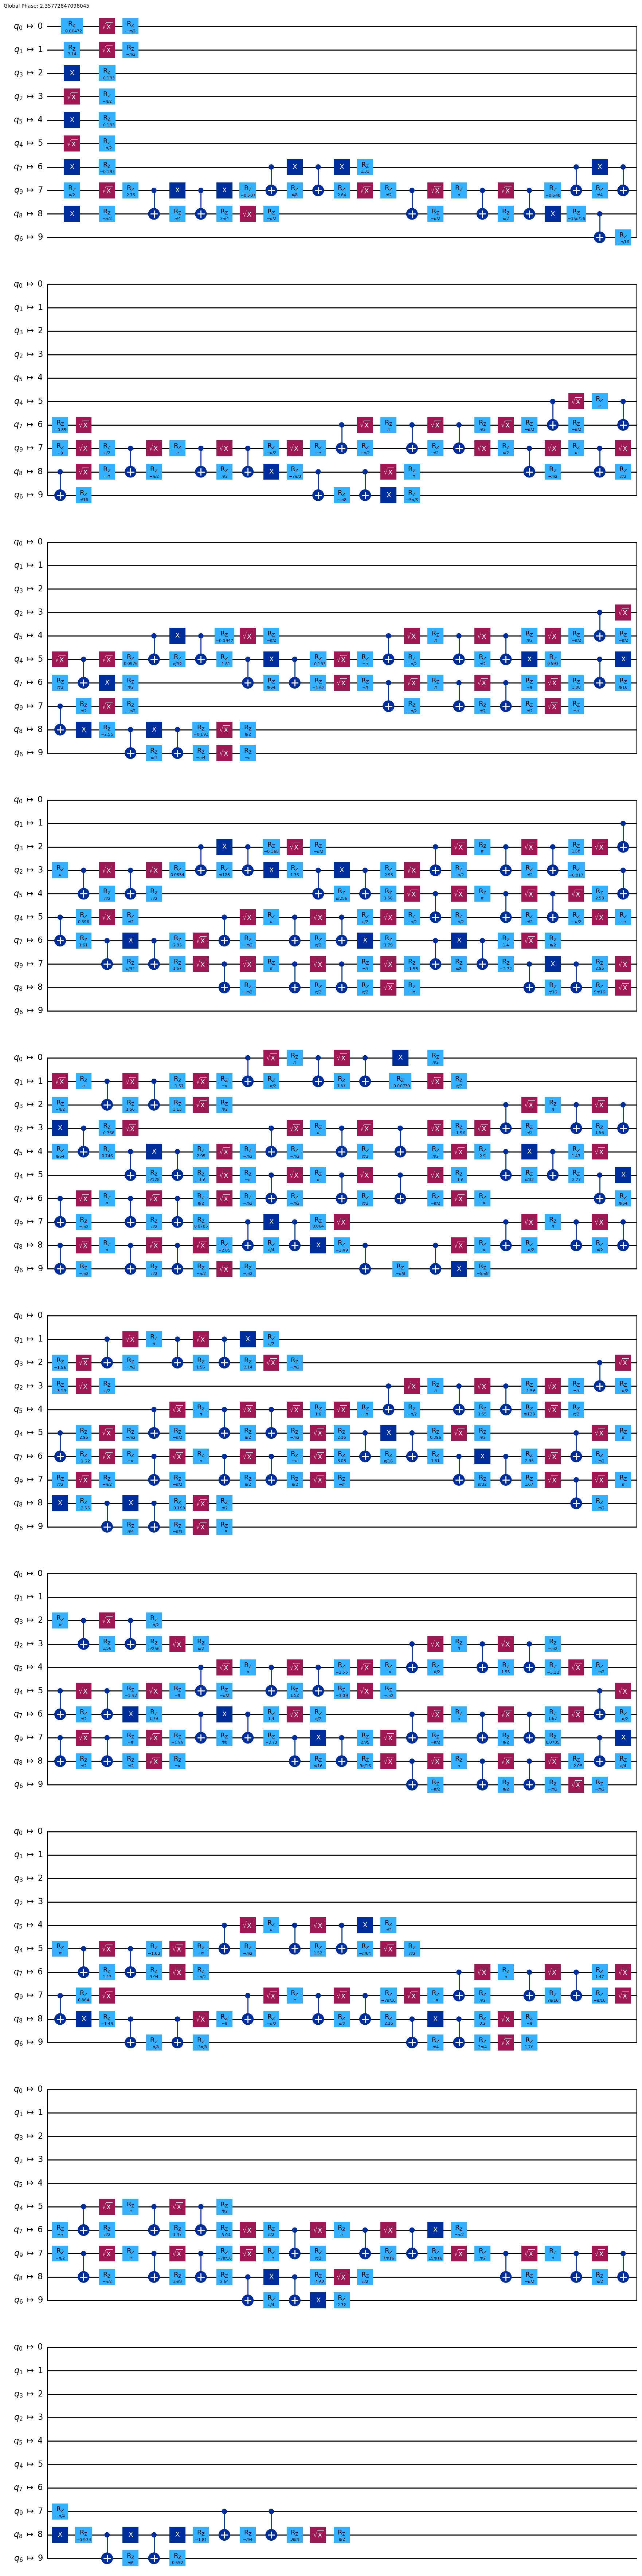

In [12]:
from qiskit.transpiler import CouplingMap
from qiskit.transpiler import PassManager 
from qiskit.transpiler import PassManagerConfig 
# #Choose which device backend you want
# to target
# • Create a preset staged pass manager
# with your desired optimization level
# • Run the staged pass manager on the
# circuit

# Supported basis gates for backend: ['cx', 'id', 'rz', 'sx', 'x', 'reset', 'delay', 'measure']
# Your work goes here!

# assign a 10-qubit linear `CouplingMap` to the variable cm'

coupling_list = []
for i in range(9): 
    coupling_list.append([i, i+1])
print(coupling_list)

cm = CouplingMap(couplinglist=coupling_list, description = "10-qubit linear CouplingMap")
# add your transpiled quantum circuit to the next line
qc_routed = transpile(qc, coupling_map= cm, optimization_level= 2, backend=backend)
# pass_manager = generate_preset_pass_manager(3, backend=backend).run(cm)
# isa_circuit = pass_manager.run(cm)
qc_routed.draw("mpl")





In [13]:
# grade your work!
grade_lab1_ex2(qc_routed)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Part 2: Build Your Own Transpiler

In this exercise, we will create our own transpiler solely by using Qiskit's customizable and extensible transpilation infrastructure. Review the information on transpilation stages discussed in the lectures and the documentation at:
* https://docs.quantum.ibm.com/transpile
* https://docs.quantum.ibm.com/api/qiskit/transpiler_plugins#plugin-stages
* https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.StagedPassManager

The transpilation in Qiskit is organized in stages that each are expected to solve one particular task. As Qiskit is applied to a variety of quantum circuits that each exhibit different structures, Qiskit's default transpilation used in the previous exercise must perform well on an arbitrary quantum circuit. It is challenging to consider the many transpilation trade-offs when developing a highly versatile transpiler, so we will focus on quantum Fourier transformation quantum circuits introduced in the previous exercise.
The goal is to produce a hardware-compliant QFT quantum circuit that contains at least 20% less two-qubit quantum gates than the quantum circuit produced by Qiskit's default transpilation!

For this, we start with a staged pass manager and successively populate the individual stages to route and synthesize the quantum circuit.
In the end of this exercise, you will need to choose one or more suitable passes for the individual stage such that the output circuit has 20% less two-qubit quantum gates than Qiskit's default transpilation.  

In [14]:
pm_staged = StagedPassManager()
# here we defined a pass manager, but it has no stages to determine sequence of pass application
# replace the n-qubit QFT operation with its decomposition in two-qubit gates
pm_staged.init = generate_unroll_3q(None)
# initialize the layout stage with an empty pass manager
pm_staged.layout = PassManager()
# set a 'trivial' initial layout, i.e. each qubit in the quantum circuit with index i 
# is mapped to the physical qubit on a device with the same index
pm_staged.layout += TrivialLayout(cm)
# do not modify the next line
pm_staged.layout += generate_embed_passmanager(cm)

# print(pm_staged.stages)

#### Exercise 2a: Routing a Quantum Circuit Through Your Own Transpiler
Start with the routing, i.e. assign a routing pass to an appropiate stage of `pm_staged`!

In [15]:
import qiskit.transpiler.preset_passmanagers
from qiskit.transpiler.passes import SabreSwap
# Your work goes here!

pm_staged.routing = PassManager()
pm_staged.routing += SabreSwap(coupling_map=cm)

# See the first cells in this notebook or
#  https://github.com/Qiskit/qiskit/tree/main/qiskit/transpiler/passes/routing for potential routing passes
# pm_staged.routing = PassManager(MyPass)
qc_routed = pm_staged.run(qc)
print_qc_characteristics(qc_routed)
qc_routed.draw(fold=-1)

Quantum circuit characteristics
  Depth: 50
  Number of qubits: 10
  Operations: {'swap': 49, 'cp': 45, 'h': 10}
  Number of multi-qubit Operations: 94


q_0 -> 0 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■────────────────────────────────────────────■─────────────X────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                          │P(π/512)                                    │P(π/256)     │                                                                                                                                                                        
q_1 -> 1 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────────────X──────■─────────────────────────────────────X──────■─────────────X─────────X──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                     │P(π/256)     │                                            │                              │                                                                                                                                                              
q_2 -> 2 ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■───────────X───■─────────────X────────────────────■─────────────X─────────X──────────────────────────────X──────────────────────────────────────────────────■─────────────X─────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                     │P(π/128)   │                                      │P(π/128)     │                                                                                           │P(π/128)     │                                                                                             
q_3 -> 3 ─────────────────────────────────────────────────────────────────────────────────────────────────────────■────────────X─────■───────────X───────X───────────────────────────X──■─────────────X───────────────────────────■───────────────────────────────■─────────X──────────────X──────■─────────────X─────■────────────X──────────────────────────────────────────────────────────────────────────
                                                                                                                  │P(π/64)     │                         │                           │                                            │P(π/64)                        │P(π/32)  │              │                          │P(π/64)     │                                                                          
q_4 -> 4 ────────────────────────────────────────────────────────────────────────────────────────────■─────────X──■────────────X──────■──────────────────X──────■─────────────X──────X─────────────■───────────────────────X──────■─────────────────────────X─────■─────────X─────X────────X──────────────────────────■────────────X─────■────────────X───────────────────────────────────────────────────────
                                                                                                     │P(π/32)  │                      │P(π/32)                  │P(π/64)      │                    │P(π/16)                │                                │                     │                                                      │P(π/32)     │                                                       
q_5 -> 5 ─

In [16]:
# grade your work!
grade_lab1_ex3(pm_staged)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


Note that the two-qubit quantum gates in the QFT quantum circuit only occur between direct neighbors, i.e. the quantum circuit can be executed on qubits that are connected as a line.
#### Exercise 2b: Synthesize a Quantum Circuit Through Your Own Transpiler
In order to establish hardware-compatibility to a quantum computer described by `backend`, the quantum circuit must be formulated by the basis gate set of `backend`.
This can be accomplished by assigning an appropiate pass to a stage of `pm_staged`.

Quantum circuit characteristics
  Depth: 189
  Number of qubits: 10
  Operations: {'cx': 246, 'rz': 155, 'sx': 10}
  Number of multi-qubit Operations: 246


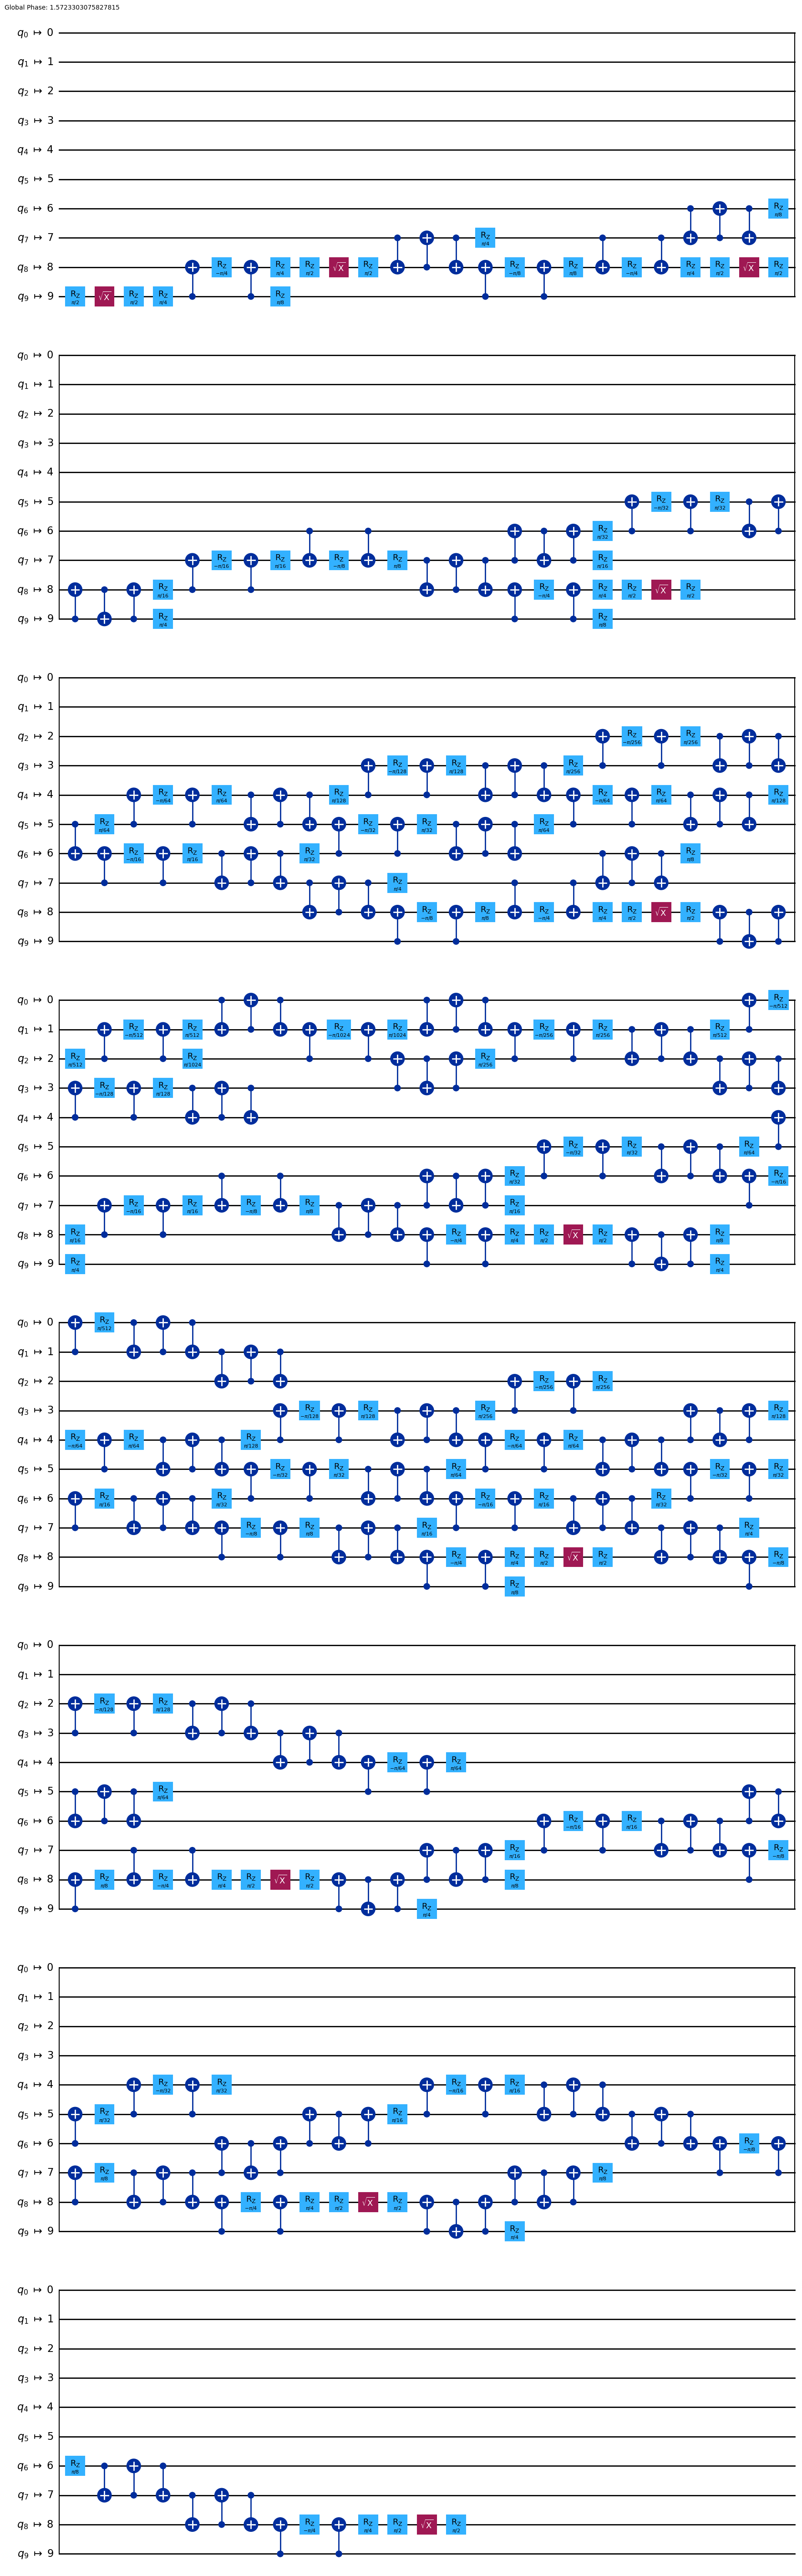

In [17]:
# Your work goes here!
from qiskit.circuit import EquivalenceLibrary
from qiskit.transpiler.passes import TranslateParameterizedGates

pm_staged.translation = PassManager()
BasisTranslator
pm_staged.translation += BasisTranslator(equivalence_library= SessionEquivalenceLibrary, target_basis= backend.operation_names)

# See the first cells in this notebook or
#   https://github.com/Qiskit/qiskit/tree/main/qiskit/transpiler/passes/synthesis for potential translation passes
# pm_staged.translation = PassManager(MyPass)
qc_routed_synth = pm_staged.run(qc)
print_qc_characteristics(qc_routed_synth)
qc_routed_synth.draw("mpl")

In [18]:
# grade your work!
grade_lab1_ex4(pm_staged)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


Now, the quantum circuit `qc_routed_synth` is compatible with the quantum computer described by `backend` and could be executed directly.
However, compared to Qiskit's default transpiler, `qc_routed_synth` is much larger:

In [19]:
qk_qc = generate_preset_pass_manager(2, backend=backend).run(qc)
print_qc_characteristics(qk_qc)

Quantum circuit characteristics
  Depth: 65
  Number of qubits: 10
  Operations: {'rz': 101, 'cx': 90, 'sx': 10}
  Number of multi-qubit Operations: 90


#### Impact of Quantum Circuit Size on Incurred Errors During Execution

On a real device, this difference in size can make the difference between a successful quantum circuit execution and an erroneous output.
We can approximate the noise in real devices in Qiskit to check the difference between Qiskit's default transpiler and our transpiler as quantified by the Hellinger fidelity:

In [20]:
def noisy_sim(qc, backend):
    # We add measurement operations to the input quantum circuit and then run it on the specified backend
    # A GenericBackendV2 automatically constructs a default model of the expected noise processes, 
    # so backend.run would return noisy simulation results    
    return backend.run(qc.measure_all(inplace=False), shots=7*1024).result().get_counts()
    

own_transpiler_sim = noisy_sim(qc_routed_synth, backend)
qiskit_transpiler_sim = noisy_sim(qk_qc, backend)
reference_sim =  noisy_sim(transpile(qc.decompose(), backend=backend), BasicSimulator())

print("Own transpiler fidelity", round(hellinger_fidelity(own_transpiler_sim, reference_sim), 4))
print("Qiskit transpiler fidelity", round(hellinger_fidelity(qiskit_transpiler_sim, reference_sim), 4))

Own transpiler fidelity 0.2097
Qiskit transpiler fidelity 0.5894


#### Exercise 2c: Exceed Qiskit's Default Transpilation on QFT Quantum Circuits 

Therefore, we try to reduce the QFT quantum circuit size after transpilation by at least 20% compared to Qiskit's default transpilation. Note that you can achieve this reduction in circuit size by only using a suitable selection of passes included in Qiskit. It is not necessary to create a new pass. Review the second half of the transpilation lecture given by Matthew Treinish to get an insight into the different transpiler stages. In particular, this exercise requires setting a routing method that works especially well on star-shaped quantum circuits in combination with an optimization stage that removes superfluous two-qubit gates in a two-qubit block. These two stages are sufficient to reduce the transpilation effort below the given 20% threshold.

Hints:
* First try to set a routing method that is especially well suited for star-shaped quantum circuits such as QFT. The routing method may appear to require a larger amount of two-qubit gates because of superfluous two-qubit gates. These should be removed by a subsequent optimization stage.
* Note that for a block of two-qubit and single-qubit gates on a pair of qubits, at most three CX gates and (up to eight) single-qubit gates are necessary. If you notice that your quantum circuit has two-qubit blocks with more CX gates, apply passes such as `UnitarySynthesis` (and its prerequisites `ConsolidateBlocks`, `Collect2qBlocks`) to rectify this.
* Reaching the 20% threshold is entirely possible by only setting the routing stage and optimization stage, other stages such as the layout stage are not required to be set to reach that threshold.
* The definition of Qiskit's default passmanagers can be inspected [here](https://github.com/Qiskit/qiskit/blob/main/qiskit/transpiler/preset_passmanagers/level3.py), [here](https://github.com/Qiskit/qiskit/blob/main/qiskit/transpiler/preset_passmanagers/common.py) and/or [here](https://github.com/Qiskit/qiskit/blob/main/qiskit/transpiler/preset_passmanagers/builtin_plugins.py). You can also inspect the included passes in a given pass manager `pm` by calling `pm.draw()`.
* You can either start with a default pass manager by calling `generate_preset_pass_manager` and modify the existing stages or define your own pass manager as shown below.

In [21]:
# Your work goes here!

pm_opt = StagedPassManager()
# Select pass managers and passes for these five stages as you see suitable, note: not every stage must contain a pass.
# Passes are documented at https://docs.quantum.ibm.com/api/qiskit/transpiler_passes

# Replace the n-qubit QFT operation with its decomposition in two-qubit gates
pm_opt.init = generate_unroll_3q(None)
# Initialize the layout stage with an empty pass manager
pm_opt.layout = PassManager()
# See the first cells in this notebook or
#   https://github.com/Qiskit/qiskit/tree/main/qiskit/transpiler/passes/layout for potential layouting passes
pm_opt.layout += TrivialLayout(cm)
# See the first cells in this notebook or
#   https://github.com/Qiskit/qiskit/tree/main/qiskit/transpiler/passes/routing for potential routing passes
pm_opt.routing = PassManager()
# pm_opt.routing += SabreSwap(coupling_map= cm)
pm_opt.routing += StarPreRouting()
# See the first cells in this notebook or
#   https://github.com/Qiskit/qiskit/tree/main/qiskit/transpiler/passes/synthesis for potential translation passes
pm_opt.translation = PassManager()
pm_opt.translation += BasisTranslator(equivalence_library= SessionEquivalenceLibrary, target_basis= backend.operation_names)
# See the first cells in this notebook or
#   https://github.com/Qiskit/qiskit/tree/main/qiskit/transpiler/passes/optimization for potential optimization passes
pm_opt.optimization = PassManager()
pm_opt.optimization +=  Collect2qBlocks()
pm_opt.optimization +=  ConsolidateBlocks(basis_gates= backend.operation_names)
pm_opt.optimization +=  UnitarySynthesis(coupling_map= cm, basis_gates= backend.operation_names)

# do not modify the next line
pm_opt.layout += generate_embed_passmanager(cm)

qc_opt = pm_opt.run(qc)

In [22]:
# grade your work!
grade_lab1_ex5(pm_opt)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


Quantum circuit characteristics
  Depth: 165
  Number of qubits: 10
  Operations: {'rz': 360, 'sx': 182, 'cx': 133, 'x': 25}
  Number of multi-qubit Operations: 133
Reduction in two-qubit gates compared to qiskit -47.778%!


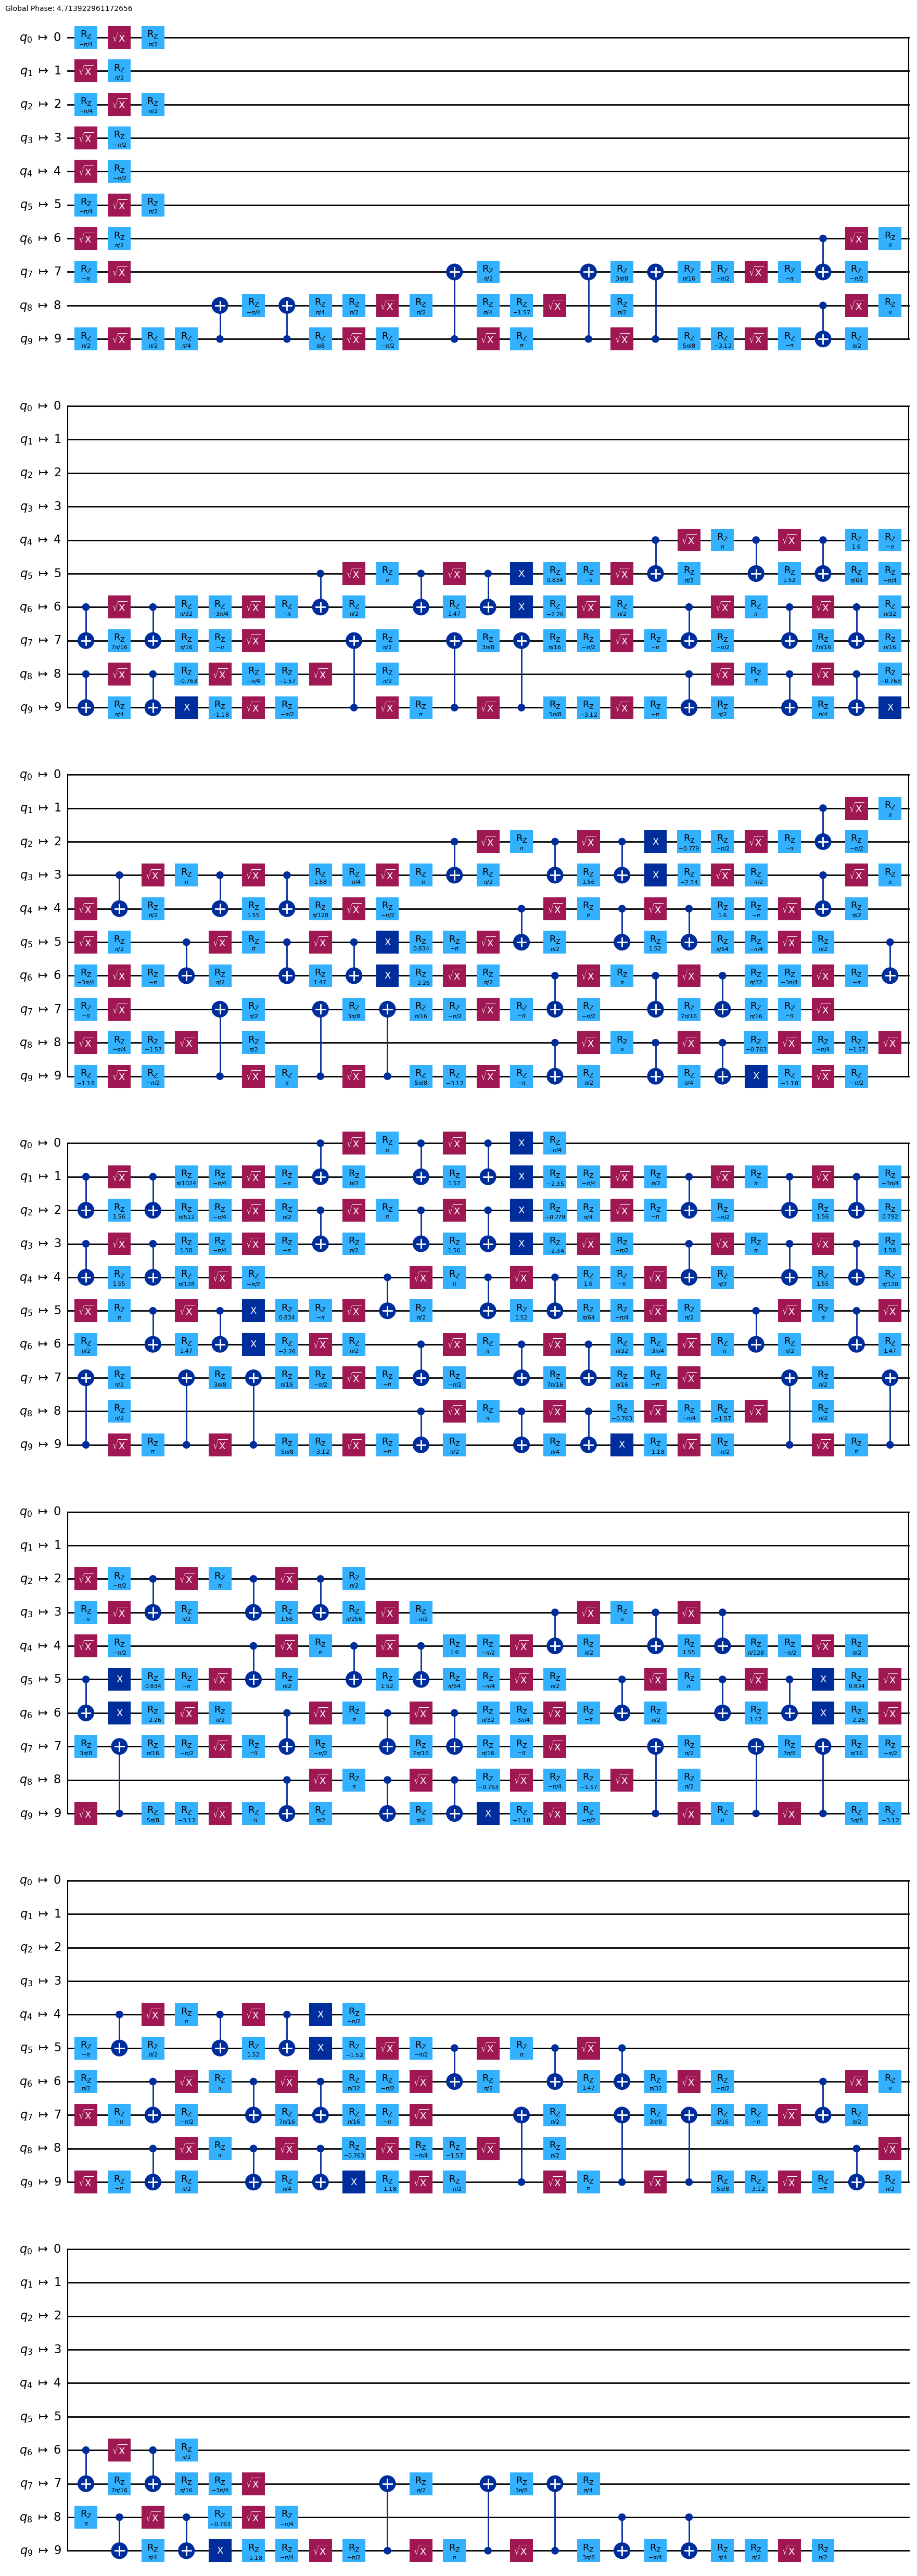

In [23]:
print_qc_characteristics(qc_opt)
reduction_ratio = round(100-100*(get_qc_characteristics(qc_opt)['num_multi_qubit_ops']/get_qc_characteristics(qk_qc)['num_multi_qubit_ops']), 3)
print("Reduction in two-qubit gates compared to qiskit {}%!".format(reduction_ratio))
qc_opt.draw("mpl")

In [24]:
opt_transpiler_sim = noisy_sim(qc_opt, backend)

print("Own transpiler fidelity", round(hellinger_fidelity(own_transpiler_sim, reference_sim), 4))
print("Qiskit transpiler fidelity", round(hellinger_fidelity(qiskit_transpiler_sim, reference_sim), 4))
print("Own optimized transpiler fidelity", round(hellinger_fidelity(opt_transpiler_sim, reference_sim), 4))

Own transpiler fidelity 0.2097
Qiskit transpiler fidelity 0.5894
Own optimized transpiler fidelity 0.9085


As you can see the reduction in quantum circuit size achieved by your pass manager had a significant impact on the expected fidelity of the quantum circuit execution!

#### Optional: Scaling-up Transpilation

When scaled up to one of the new 133-qubit Heron quantum computers, the reduction in two-qubit quantum gates may even be higher.
Adapt the developed `pm_opt` pass manager for a 133-qubit Heron quantum computer and run it on a 100-qubit QFT quantum circuit.
Check out the [IBM Quantum roadmap](https://www.ibm.com/roadmaps/quantum/) to see how much earlier the quantum circuit generated by your pass manager is expected to be executable compared to the quantum circuit yielded by Qiskit's default transpilation!

In [25]:
# Your work here! (optional!)

In [26]:
# # grade your work!
# num_qubits = 100
# qc = QFT(num_qubits, do_swaps=False)
# # Define a backend whose basis gate set and coupling map corresponds to a 133-qubit Heron quantum computer
# target_backend = None

# pm_student = None
# qc_student = pm_student.run(qc)
# qc_qiskit = generate_preset_pass_manager(2, backend=target_backend).run(qc)
# reduction_ratio = round(100-100*(get_qc_characteristics(qc_student)['num_multi_qubit_ops']/get_qc_characteristics(qc_qiskit)['num_multi_qubit_ops']), 3)

# print("Reduction in two-qubit gates compared to qiskit {}%!".format(reduction_ratio))
# print("N-qubit gates generated by Qiskit's default pass manager:", get_qc_characteristics(qc_qiskit)['num_multi_qubit_ops'])
# print("N-qubit gates generated by your pass manager", get_qc_characteristics(qc_student)['num_multi_qubit_ops'])

### Part 3: Develop Transpiler Passes
In this exercise we will extend the transpilation capabilities of qiskit by developing our own transpiler passes!
When a transpiler pass is part of Qiskit, other users can include them in their custom transpiler to yield hardware-compliant quantum circuits with reduced size as in the previous exercise.
Transpiler passes are roughly divided into analysis passes that determine a property or quantity of a given quantum circuit and transformation passes that transform (or modify) a given quantum circuit.

In general, transpiler passes perform computations on a graph data structure called the `DAGCircuit` and store information in a `property_set`.
Transformation passes return a `DAGCircuit` while analysis passes only store the determined information in a `property_set` without returning a `DAGCircuit`.

The documentation on `DAGCircuit` is available on:
* https://docs.quantum.ibm.com/api/qiskit/qiskit.dagcircuit.DAGCircuit
* https://www.rustworkx.org/tutorial/dags.html
* https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/circuits_advanced/04_transpiler_passes_and_passmanager.ipynb
  
For the remaining exercises, we will specifically need the methods in `DAGCircuit` that allow to iterate over the content of the `DAGCircuit` and methods that allow to substitute parts of the `DAGCircuit`.
For documentation on the `property_set`, see https://docs.quantum.ibm.com/api/qiskit/qiskit.passmanager.PropertySet and for documentation on creating custom transpiler passes, see https://docs.quantum.ibm.com/transpile/custom-transpiler-pass.


In [27]:
# from qiskit.circuit import Qubit
# dagger = circuit_to_dag(qc_opt)

# qubit = Qubit(dagger.qregs, 5)

#### Exercise 3a: Develop an Analysis Pass

Let's start with a analysis pass that determines the number of two-qubit gates and single-qubit gates on each qubit and stores this in the `property_set` using the keys `"one_q_op"` and `"two_q_op"` respectively. For each of these keys, one dictionary should be added at `property_set["one_q_op"]` and `property_set["two_q_op"]` where a dictionary contains each qubit as a key and the respective gate count of the qubit as a value, i.e. the type of both dictionaries should be `Dict[Qubit, int]`.


In [28]:
from qiskit.passmanager import PropertySet
from qiskit.passmanager import PassManagerState
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.circuit import Qubit

class GatesPerQubit(AnalysisPass):

    def run(self, dag:DAGCircuit):

        one_q_op_dict = {}
        two_q_op_dict = {}

        for dagopnode in dag.collect_1q_runs():
            for node in dagopnode: 
                qubit = node.qargs[0]
                one_q_op_dict[qubit] = one_q_op_dict.get(qubit, 0) + 1


        for dagopnode in dag.collect_2q_runs():
            for node in dagopnode: 
                qubits = node.qargs
                if node.op.num_qubits == 2:
                    for qubit in qubits:
                        if isinstance(qubit, Qubit):
                            two_q_op_dict[qubit] = two_q_op_dict.get(qubit, 0) + 1
                        

        self.property_set["one_q_op"] = one_q_op_dict
        self.property_set["two_q_op"] = two_q_op_dict

In [29]:
# one_q_op_dict = {}
# two_q_op_dict = {}

# for dagopnode in (circuit_to_dag(qc_opt)).collect_1q_runs():
#     for node in dagopnode: 
#         qubit = node.qargs[0]
#         one_q_op_dict[qubit] = one_q_op_dict.get(qubit, 0) + 1


# for dagopnode in (circuit_to_dag(qc_opt)).collect_2q_runs():
#     for node in dagopnode: 
#         qubit = node.qargs[0]
#         two_q_op_dict[qubit] = two_q_op_dict.get(qubit, 0) + 1
    
# property_set_test = {}

# property_set_test["one_q_op"] = one_q_op_dict
# property_set_test["two_q_op"] = two_q_op_dict

# print(property_set_test["two_q_op"])

In [30]:
# grade your work!
grade_lab1_ex6(GatesPerQubit)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


We can now apply your new analysis pass to a transpiled QFT circuit and print the number of two-qubit and single-qubit gates on each qubit.

In [31]:
qc = QFT(4, do_swaps=False)
qc = generate_preset_pass_manager(2, backend=backend).run(qc)
gpq = GatesPerQubit()
gpq(qc)
print("single-qubit gates on qubit", gpq.property_set["one_q_op"])
print("two-qubit gates on qubit", gpq.property_set["two_q_op"])
qc.draw(fold=-1, idle_wires=False)

single-qubit gates on qubit {Qubit(QuantumRegister(10, 'q'), 4): 3, Qubit(QuantumRegister(10, 'q'), 5): 4, Qubit(QuantumRegister(10, 'q'), 0): 6, Qubit(QuantumRegister(10, 'q'), 8): 8}
two-qubit gates on qubit {Qubit(QuantumRegister(10, 'q'), 4): 6, Qubit(QuantumRegister(10, 'q'), 5): 6, Qubit(QuantumRegister(10, 'q'), 0): 6, Qubit(QuantumRegister(10, 'q'), 8): 6}


global phase: 0
                                                                 ┌───┐    ┌──────────┐   ┌───┐    ┌─────────┐    ┌───┐    ┌──────────┐   ┌───┐    ┌──────────┐   ┌────┐   ┌──────────┐                                                              
q_1 -> 0 ────────────────────────────────────────────────────────┤ X ├────┤ Rz(-π/8) ├───┤ X ├────┤ Rz(π/8) ├────┤ X ├────┤ Rz(-π/4) ├───┤ X ├────┤ Rz(3π/4) ├───┤ √X ├───┤ Rz(3π/4) ├─────────────■────────────────■───────────────────────────────
         ┌─────────┐┌────┐┌────────────┐                         └─┬─┘    └──────────┘   └─┬─┘    └─────────┘    └─┬─┘    └──────────┘   └─┬─┘    └──────────┘   └────┘   └──────────┘             │                │                               
q_3 -> 4 ┤ Rz(π/2) ├┤ √X ├┤ Rz(15π/16) ├──■────────────────■───────■───────────────────────■───────────■───────────┼───────────■───────────┼───────────────────────────────────────────────────────┼────────────────┼───────────────────────────────
         └─────────┘└────┘└────────────┘┌─┴─┐┌──────────┐┌─┴─┐┌──────────┐   ┌────┐   ┌──────────┐     │           │           │           │                                                       │                │                               
q_2 -> 5 ───────────────────────────────┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(3π/4) ├───┤ √X ├───┤ Rz(7π/8) ├─────┼───────────■───────────┼───────────■───────────■───────────────────────■───────────────────┼────────────────┼───────────────────────────────
                                        └───┘└──────────┘└───┘└──────────┘   └────┘   └──────────┘   ┌─┴─┐   ┌───────────┐   ┌─┴─┐    ┌──────────┐   ┌─┴─┐    ┌──────────┐   ┌─┴─┐    ┌─────────┐┌─┴─┐┌──────────┐┌─┴─┐┌──────────┐┌────┐┌─────────┐
q_0 -> 8 ────────────────────────────────────────────────────────────────────────────────────────────┤ X ├───┤ Rz(-π/16) ├───┤ X ├────┤ Rz(π/16) ├───┤ X ├────┤ Rz(-π/8) ├───┤ X ├────┤ Rz(π/8) ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(3π/4) ├┤ √X ├┤ Rz(π/2) ├
                                                                                                     └───┘   └───────────┘   └───┘    └──────────┘   └───┘    └──────────┘   └───┘    └─────────┘└───┘└──────────┘└───┘└──────────┘└────┘└─────────┘

Next, we not only want to gather information about a quantum circuit but also transform it in a way that makes it hardware-compliant with an IBM quantum computer.
#### Exercise 3b: Develop a Transformation Pass
We will develop a `TransformationPass` in this exercise to define a quantum circuit transformation and run it on a certain input circuit that includes 'Peres' quantum gates.
Peres quantum gates can not be executed directly on an IBM quantum computer and are not included in Qiskit by default.
Instead, they must be replaced in the input quantum circuit by gates from the basis gate set of the target quantum computer, i.e. `backend.operation_names=['cx', 'id', 'rz', 'sx', 'x', 'reset', 'delay', 'measure']`.

The 'Peres' quantum gate (_PG_) is defined on three qubits as

$PG = \left({\begin{array}{cc}1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 1 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\\end{array}}\right)$


and within Qiskit as a `Gate` object as

In [32]:
pg = Gate('Peres', 3, params=[], label='PG')


with the following visualization.

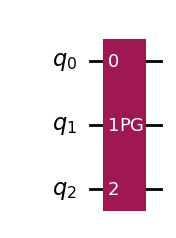

In [33]:
qc_pg = QuantumCircuit(3)
qc_pg.append(pg, [0,1,2])
qc_pg.draw("mpl")

The input quantum circuit `qc_in` for this exercise is defined by:

In [34]:
def get_qc_in(nq):
    # QFT circuit, feel free to use a previously defined pass manager for the QFT circuit 
    qc_qft = QFT(nq, do_swaps=False)
    # part of the circuit including the Peres gate
    qc_inner = QuantumCircuit(nq)
    for i in range(1, nq-1):
        qc_inner.append(pg, [nq-i-2, nq-i-1, nq-1])
    
    qc_in = QuantumCircuit(nq)
    # add QFT circuit to qc_in
    qc_in.compose(qc_qft, range(nq), inplace=True)

    # perform swap gates
    for i in range(nq // 2):       
        qc_in.cx(i, nq - i - 1)
        qc_in.cx( nq - i - 1, i)
        qc_in.cx(i, nq - i - 1)
        
    qc_in.rz(pi, nq-1)
    # add circuit with peres gates
    qc_in.compose(qc_inner, range(nq), inplace=True)
    
    # perform swap gates
    for i in range(nq // 2):
        qc_in.cx(i, nq - i - 1)
        qc_in.cx( nq - i - 1, i)
        qc_in.cx(i, nq - i - 1)
    # add inverse QFT circuit
    qc_in.compose(qc_qft.inverse(), range(nq), inplace=True)
    return qc_in

nq = 5
qc_in = get_qc_in(nq)
qc_in.draw(fold=-1)

┌──────┐          ┌───┐                                 ┌─────┐          ┌───┐               ┌───────┐
q_0: ┤0     ├──■───────┤ X ├───────■─────────────────────────┤0    ├──■───────┤ X ├───────■───────┤0      ├
     │      │  │       └─┬─┘┌───┐  │                  ┌─────┐│     │  │       └─┬─┘┌───┐  │       │       │
q_1: ┤1     ├──┼────■────┼──┤ X ├──┼──────■───────────┤0    ├┤1    ├──┼────■────┼──┤ X ├──┼────■──┤1      ├
     │      │  │    │    │  └─┬─┘  │      │    ┌─────┐│     ││     │  │    │    │  └─┬─┘  │    │  │       │
q_2: ┤2 QFT ├──┼────┼────┼────┼────┼──────┼────┤0    ├┤1    ├┤  PG ├──┼────┼────┼────┼────┼────┼──┤2 IQFT ├
     │      │  │  ┌─┴─┐  │    │    │    ┌─┴─┐  │     ││  PG ││     │  │  ┌─┴─┐  │    │    │  ┌─┴─┐│       │
q_3: ┤3     ├──┼──┤ X ├──┼────■────┼────┤ X ├──┤1 PG ├┤     ├┤     ├──┼──┤ X ├──┼────■────┼──┤ X ├┤3      ├
     │      │┌─┴─┐└───┘  │       ┌─┴─┐┌─┴───┴─┐│     ││     ││     │┌─┴─┐└───┘  │       ┌─┴─┐└───┘│       │
q_4: ┤4     ├┤ X ├───────■───────┤ X ├┤ Rz(π) ├┤2    ├┤2    ├┤2    ├┤ X ├───────■───────┤ X ├─────┤4      ├
     └──────┘└───┘               └───┘└───────┘└─────┘└─────┘└─────┘└───┘               └───┘     └───────┘

where *PG* is the Peres gate, *QFT* is the quantum Fourier tranformation circuit introduced in this lab and *IQFT* is its inverse (accessible via `qc.inverse()`).

In the previous exercises, we investigated how to make the QFT circuit compliant to the basis gate set of a target quantum computer. In this exercise, we will develop a transformation pass for the remaining gates of `qc_in`. Use the decomposition in method `get_peres_decomposition` to develop the `TransformationPass`.

In [41]:
from qiskit.dagcircuit import DAGCircuit, DAGOpNode
class PeresGateTranslation(TransformationPass):
    
    def get_peres_decomposition(self):
        
        qcsx = QuantumCircuit(2)
        qcsx.rz(pi / 4, 0)
        qcsx.rz(pi / 2, 1)
        qcsx.sx(1)
        qcsx.rz(pi / 2, 1)
        qcsx.cx(0, 1)
        qcsx.rz(-pi / 4, 1)
        qcsx.cx(0, 1)
        qcsx.rz(3 * pi / 4, 1)
        qcsx.sx(1)
        qcsx.rz(pi / 2, 1)

        qcsx_inv = QuantumCircuit(2)
        qcsx_inv.rz(pi / 4, 1)
        qcsx_inv.cx(0, 1)
        qcsx_inv.rz(-pi / 4, 1)
        qcsx_inv.cx(0, 1)
        qcsx_inv.rz(pi / 2, 0)
        qcsx_inv.rz(pi / 2, 1)
        qcsx_inv.cx(0, 1)
        qcsx_inv.rz(pi / 2, 1)            
        qcsx_inv.sx(1)
        qcsx_inv.rz(-3 * pi / 4, 1)
        qcsx_inv.sx(1)
        qcsx_inv.cx(0, 1)
        qcsx_inv.sx(1)
        qcsx_inv.rz(-3 * pi / 4, 1)
        qcsx_inv.sx(1)
        qcsx_inv.rz(-3 * pi / 4, 1)
        qcsx_inv.cx(0, 1)
        qcsx_inv.rz(-pi / 4, 1)
        qcsx_inv.cx(0, 1)
        qcsx_inv.rz(pi / 4, 0)
    
        qc_dec = QuantumCircuit(3)
        qc_dec.cx(0, 1)
        qc_dec.cx(1, 0)
        qc_dec.cx(0, 1)
        qc_dec.compose(qcsx, [1, 2], inplace=True)
        qc_dec.cx(0, 1)
        qc_dec.cx(1, 0)
        qc_dec.cx(0, 1)
        qc_dec.compose(qcsx, [1, 2], inplace=True)
        qc_dec.cx(0, 1)
        qc_dec.compose(qcsx_inv, [1, 2], inplace=True)
        qc_dec.cx(0, 1)
        qc_dec.cx(0, 1)
        return qc_dec
        
    def run(self, dag:DAGCircuit):
        decomposition = circuit_to_dag(self.get_peres_decomposition())
        dag_op_nodes = dag.gate_nodes()
        for node in dag_op_nodes:
            if isinstance(node, DAGOpNode) and node.op.name == 'Peres':
                print(node)
                dag.substitute_node_with_dag(node, decomposition)
                print(node)
        return dag

    # Your work here - make sure you implement every abstract method defined by
    #  https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.TransformationPass!

In [42]:
dag_circuit = circuit_to_dag(qc_in)
print(dag_circuit.gate_nodes())

[DAGOpNode(op=Instruction(name='QFT', num_qubits=5, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(5, 'q'), 0), Qubit(QuantumRegister(5, 'q'), 1), Qubit(QuantumRegister(5, 'q'), 2), Qubit(QuantumRegister(5, 'q'), 3), Qubit(QuantumRegister(5, 'q'), 4)), cargs=()), DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(5, 'q'), 0), Qubit(QuantumRegister(5, 'q'), 4)), cargs=()), DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(5, 'q'), 4), Qubit(QuantumRegister(5, 'q'), 0)), cargs=()), DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(5, 'q'), 0), Qubit(QuantumRegister(5, 'q'), 4)), cargs=()), DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(5, 'q'), 1), Qubit(QuantumRegister(5, 'q'), 3)), cargs=()), DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, para

In [43]:
# grade your work!
grade_lab1_ex7(PeresGateTranslation, pg)

1463689243408
1463689243408
1463689244768
1463689244768
1463689239888
1463689239888
Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


Congratulations! You finished Lab 1 of the IBM's Qiskit Global Summer School 2024! 🎉 🎉 🎉

#### Optional: Quantum Circuit Optimization
As a last optional exercise, reduce the overhead of transpiling `qc_in` (the quantum circuit from exercise 3b) for the target quantum computer defined in the last optional exercise with any of the approaches you have been made familiar with during this exercise!

In [38]:
# Your code here! (Optional!)

Made with ❤ by Sebastian Brandhofer and the Qiskit Developers.

In [39]:
import datetime
from IPython.display import HTML, display


def qiskit_copyright(line="", cell=None):
    """IBM copyright"""
    now = datetime.datetime.now()

    html = "<div style='width: 100%; background-color:#d5d9e0;"
    html += "padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>"
    html += "<p>&copy; Copyright IBM 2017, %s.</p>" % now.year
    html += "<p>This code is licensed under the Apache License, Version 2.0. You may<br>"
    html += "obtain a copy of this license in the LICENSE.txt file in the root directory<br> "
    html += "of this source tree or at http://www.apache.org/licenses/LICENSE-2.0."

    html += "<p>Any modifications or derivative works of this code must retain this<br>"
    html += "copyright notice, and modified files need to carry a notice indicating<br>"
    html += "that they have been altered from the originals.</p>"
    html += "</div>"
    return display(HTML(html))


qiskit_copyright()